In [1]:
import cv2 as cv
import numpy as np
from util_func import *

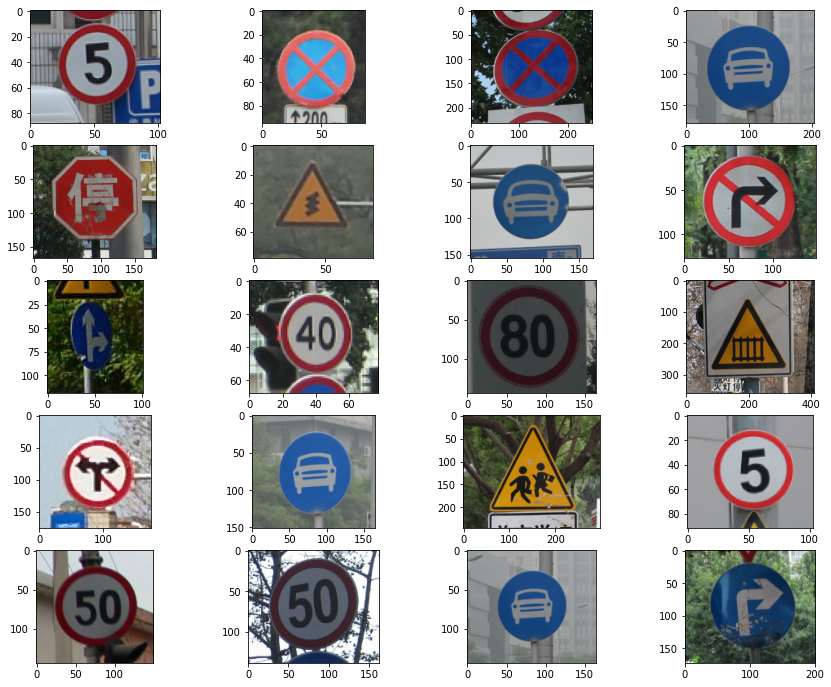

In [2]:
import matplotlib.pyplot as plt
import os

files = np.random.choice(os.listdir("images/"), size=20, replace=False)
img_dir = "images/"

plt.figure(figsize=(15, 12))
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    
plt.show()

In [3]:
import pandas as pd

annotations = pd.read_csv("TsignRecgTrain4170Annotation.txt", sep=";", header=None)
annotations.head()

,0,1,2,3,4,5,6,7,8
0,000_0001.png,134,128,19,7,120,117,0,NaN
1,000_0002.png,165,151,23,12,149,138,0,NaN
2,000_0003.png,128,122,22,14,116,105,0,NaN
3,000_0010.png,80,73,14,8,67,63,0,NaN
4,000_0011.png,186,174,36,15,155,157,0,NaN


In [4]:
img = cv.imread("images/000_0011.png")
img.shape

(174, 186, 3)

In [5]:
annotations.drop([8], axis=1, inplace=True)

In [6]:
annotations.columns = ["filenames", "width", "height", "x_start", "y_start", "x_end", "y_end", "labels"]
annotations.head()

,filenames,width,height,x_start,y_start,x_end,y_end,labels
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


In [7]:
annotations.set_index("filenames", inplace=True)
annotations.head()

,width,height,x_start,y_start,x_end,y_end,labels
filenames,,,,,,,
000_0001.png,134,128,19,7,120,117,0
000_0002.png,165,151,23,12,149,138,0
000_0003.png,128,122,22,14,116,105,0
000_0010.png,80,73,14,8,67,63,0
000_0011.png,186,174,36,15,155,157,0


In [8]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4170 entries, 000_0001.png to 056_1_0054.png
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   width    4170 non-null   int64
 1   height   4170 non-null   int64
 2   x_start  4170 non-null   int64
 3   y_start  4170 non-null   int64
 4   x_end    4170 non-null   int64
 5   y_end    4170 non-null   int64
 6   labels   4170 non-null   int64
dtypes: int64(7)
memory usage: 260.6+ KB


In [9]:
def contrast_enhance(img):
    img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    L = cv.equalizeHist(L)
    img_lab_merge = cv.merge((L, a, b))
    return cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)

In [10]:
# canny edge detection
def auto_canny(img, method, sigma=0.33):
    """
    Args:
    img: grayscale image
    method: Otsu, triangle, and median
    sigma: 0.33 (default)
    2 outputs:
    edge_detection output, the high threshold"""
    if method=="median":
        Th = np.median(img)
        
    elif method=="triangle":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)
        
    elif method=="otsu":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_OTSU)
        
    else:
        raise Exception("method specified not available!")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh), highTh

In [11]:
# Color based segmentation
# Color based segmentation (red, blue, yellow, black)
# Red color
lower_red1 = (0, 40, 50)
upper_red1 = (10, 255, 210)
lower_red2 = (165, 40, 50)
upper_red2 = (179, 255, 210)

# Blue color 
lower_blue = (90, 40, 50)
upper_blue = (120, 255, 210)

# Yellow colors
lower_yellow = (20, 40, 50)
upper_yellow = (35, 255, 210)

# black colors
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_seg(img, kernel_size=None):
    """Args:
    img: image in bgr
    kernel_size: None (default:(3, 3))"""
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask_red1 = cv.inRange(hsv_img, lower_red1, upper_red1)
    mask_red2 = cv.inRange(hsv_img, lower_red2, upper_red2)
    mask_blue = cv.inRange(hsv_img, lower_blue, upper_blue)
    mask_yellow = cv.inRange(hsv_img, lower_yellow, upper_yellow)
    mask_black = cv.inRange(hsv_img, lower_black, upper_black)
    
    mask_combined = mask_red1 | mask_red2 | mask_blue | mask_yellow | mask_black
    
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined

In [12]:
# rectangle detection (using Douglas-Peuker algorithm)
def cnt_rect(cnts, coef=0.1):
    contour_list = []
    for cnt in cnts:
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, coef*peri, True)
        if len(approx) == 4:
            contour_list.append(cnt)

    if not contour_list:
        return None
    else:
        LC = max(contour_list, key=cv.contourArea)
        return LC
    
# circle detection
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200,    # adaptively change according to image
    "param2": 15,  
    "minRadius": 10,
    "maxRadius": 100
}
def cnt_circle(img, hough_dict):
    """Args:
    img: Grayscale Image after resizing
    cnt: contour
    hough_dict: hough_circle_transform parameters"""
    mask = np.zeros_like(img)
    circles = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles is None:
        return circles
    else:
        # perform LCA
        list_circles = circles[0]
        largest_circles = max(list_circles, key=lambda x: x[2])
        center_x, center_y, r = largest_circles
        cv.circle(mask, (int(center_x), int(center_y)), int(r), 255)
        cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnt = cnts[0]
        if len(cnts[0])>0:
            return max(cnt, key=cv.contourArea)
        else:
            return cnt[-1]

In [13]:
# combine the results of 2 shape detectors
def integrate_circle_rect(rect_cnt, circle_cnt, cnt):
    if circle_cnt is not None and rect_cnt is not None:
        # compare the area
        if cv.contourArea(circle_cnt) >= cv.contourArea(rect_cnt):
            output = circle_cnt
        else:
            output = rect_cnt

    elif circle_cnt is not None and rect_cnt is None:
        output = circle_cnt

    elif circle_cnt is None and rect_cnt is not None:
        output = rect_cnt

    else:
        if len(cnt)==0:
            return np.array([])
        else:
            output = max(cnt, key=cv.contourArea)

    return output

In [14]:
# combine the results of edge detector + color based segmentation followed by shape detection combined results
def integrate_edge_color(output1, output2):
    if not isinstance(output1, np.ndarray):
        output1 = np.array(output1)
        
    if not isinstance(output2, np.ndarray):
        output2 = np.array(output2)
        
    if len(output1)==0 and len(output2)==0:
        return np.array([])
    
    elif len(output1)==0 and output2.shape[-1]==2:
        return output2
    
    elif len(output2)==0 and output1.shape[-1]==2:
        return output1
    
    else:
        if cv.contourArea(output1[0]) > cv.contourArea(output2[0]):
            return output1
        else:
            return output2

In [15]:
# Calculate the IoU between two bounding boxes
def computeIOU(boxA, boxB):
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [16]:
len(np.array([]))

0

In [31]:
from skimage.exposure import is_low_contrast
from pathlib import Path

img_dir = Path("images")

IOUs = []
i = 0
fixed_width = 200
files_no_det = []
img_iou_zero = []
for file in img_dir.glob("*.png"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    if img is None:
        print("No such file exists")
        break
    img_copy = img.copy()
    i += 1
    filename = str_fn.split("\\")[-1]
    
    # Denoise the image + change to grayscale
    img_denoised = cv.medianBlur(img_copy, 3)
    if is_low_contrast(img_denoised):
        img_denoised = contrast_enhance(img_denoised)
    # Resize the image
    ratio = fixed_width / img.shape[1]
    img_resized = cv.resize(img_denoised, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)
    
    # change to grayscale
    gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

    #1: Edge detection + shape detection + combine results of shape detector
    edge, canny_th2 = auto_canny(gray, "otsu")

    # Perform shape detectors
    cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    rect_edge = cnt_rect(cnt)

    hough_circle_parameters["param1"] = canny_th2
    circle_edge = cnt_circle(gray, hough_circle_parameters)

    output1 = integrate_circle_rect(rect_edge, circle_edge, cnt_edge)

    # color segmentation
    color_segmented = color_seg(img_resized)

    # perform rectangular object detection
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = cnt_rect(cnt)

    # perform circular object detection
    hough_circle_parameters["param1"] = 200
    circle = cnt_circle(color_segmented, hough_circle_parameters)

    output2 = integrate_circle_rect(rect, circle, cnt)
    
    # ground truth bb
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    gt_bb = (gt_bb*ratio).astype(int)

    cv.rectangle(img_resized, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    
    # integrate output1 and output2
    final_output = integrate_edge_color(output1, output2)
    if len(final_output) == 0:
        print("no detection!")
        show_img("no detection", img_resized)
        IOUs.append(0)
        files_no_det.append(str_fn)
    else:
        x, y, w, h = cv.boundingRect(final_output)
        cv.rectangle(img_resized, (x, y), (x+w, y+h), (0, 255, 0), 2)

        pred_bb = (x, y, x+w, y+h)

        IOU = computeIOU(gt_bb, pred_bb)

        cv.putText(img_resized, f"IOU: {IOU:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
        IOUs.append(IOU)
        
        if IOU==0:
            img_iou_zero.append(img_resized)
        
        if i % 1000 == 0:
            show_img("results", img_resized)

### Results analysis

In [32]:
IOU_series = pd.Series(IOUs)
IOU_series.describe()

count    4170.000000
mean        0.702706
std         0.322274
min         0.000000
25%         0.568851
50%         0.854760
75%         0.945490
max         1.000000
dtype: float64

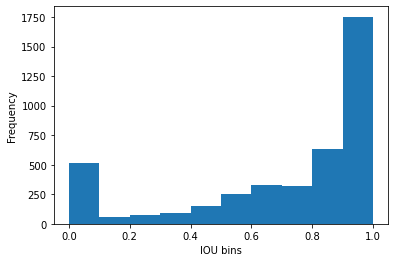

In [33]:
# Histogram
IOU_series.hist()
plt.xlabel("IOU bins"), plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [34]:
len(img_iou_zero)

236

In [35]:
len(files_no_det)

0

In [36]:
arr_IOU = np.array(IOUs)
(arr_IOU>=0.5).sum()

3282

In [37]:
print(f"The proportion of good segmentation: {round((arr_IOU>=0.5).sum() / 4170, 4)}")

The proportion of good segmentation: 0.7871


### Zero IOU images

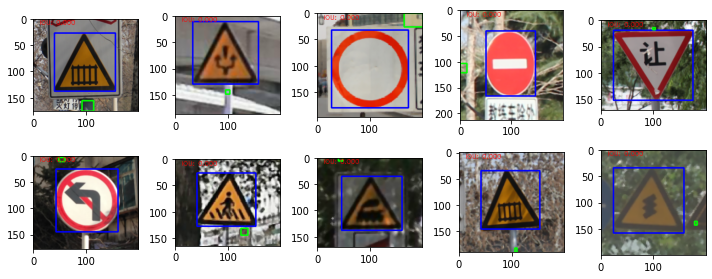

In [71]:
import random
idx_images = np.arange(len(img_iou_zero))

idx_random_images = np.random.choice(idx_images, 10, replace=False)

fig = plt.figure(figsize=(10, 4))

for i_plot, i_img in enumerate(idx_random_images):
    plt.subplot(2, 5, i_plot+1)
    image = img_iou_zero[i_img]
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
plt.tight_layout()
plt.show()

In [73]:
cv.__version__

'4.5.5'